# Building Models for Building Energy Prediction

## Table of Contents
*  
    * [Part 1 : Data Loading, Transformation and Exploration](#part-1)
    * [Part 2 : Feature extraction and ML training](#part-2)
    * [Part 3 : Hyperparameter Tuning and Model Optimisation](#part-3)  
Please add code/markdown cells as needed.

# Part 1: Data Loading, Transformation and Exploration <a class="anchor" name="part-1"></a>
## 1.1 Data Loading
In this section, you must load the given datasets into PySpark DataFrames and use DataFrame functions to process the data. For plotting, various visualisation packages can be used, but please ensure that you have included instructions to install the additional packages and that the installation will be successful in the provided Docker container (in case your marker needs to clear the notebook and rerun it).

### 1.1.1 Data Loading <a class="anchor" name="1.1"></a>
1.1.1 Write the code to create a SparkSession. For creating the SparkSession, you need to use a SparkConf object to configure the Spark app with a proper application name, to ensure the maximum partition size does not exceed 32MB, and to run locally with all CPU cores on your machine

In [1]:
# Import SparkConf class into program
from pyspark import SparkConf

master = "local[*]"
app_name = "A2A"

# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# Configure maximum partition size to 32MB
spark_conf.set("spark.sql.files.maxPartitionBytes", "32MB")

# Import SparkContext and SparkSession classes
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# Method 1: Using SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

1.1.2 Write code to define the schemas for the datasets, following the data types suggested in the metadata file. 

In [2]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType


# Define schema for meters table
meter_schema = StructType([
    StructField("building_id", IntegerType(), True),
    StructField("meter_type", StringType(), True),
    StructField("ts", TimestampType(), True),
    StructField("value", DoubleType(), True),
    StructField("row_id", IntegerType(), True)
])

# Define schema for building table
building_schema = StructType([
    StructField("site_id", IntegerType(), True),
    StructField("building_id", IntegerType(), True),
    StructField("primary_use", StringType(), True),
    StructField("square_feet", IntegerType(), True),
    StructField("floor_count", IntegerType(), True),
    StructField("row_id", IntegerType(), True),
    StructField("year_built", IntegerType(), True),
    StructField("latent_y", DoubleType(), True),
    StructField("latent_s", DoubleType(), True),
    StructField("latent_r", DoubleType(), True)
])


# Define schema for weather information
weather_schema = StructType([
    StructField("site_id",IntegerType(), True),
    StructField("timestamp",TimestampType(), True),
    StructField("air_temperature",DoubleType(), True),
    StructField("cloud_coverage",IntegerType(), True),
    StructField("dew_temperature",DoubleType(), True),
    StructField("sea_level_pressure",DoubleType(), True),
    StructField("wind_direction",IntegerType(), True),
    StructField("wind_speed",DoubleType(), True),
    
])

1.1.3 Using your schemas, load the CSV files into separate data frames. Print the schemas of all data frames. 

In [3]:
file_path = "dataset/meters.csv"
meter_df = spark.read.csv(file_path, header=True, schema=meter_schema, sep=',')
print(f'Meter table:')
meter_df.printSchema()

file_path = "dataset/building_information.csv"
building_df = spark.read.csv(file_path, header=True, schema=building_schema, sep=',')
print(f'Building table:')
building_df.printSchema()


file_path = "dataset/weather.csv"
weather_df = spark.read.csv(file_path, header=True, schema=weather_schema, sep=',')
print(f'Weather table:')
weather_df.printSchema()

Meter table:
root
 |-- building_id: integer (nullable = true)
 |-- meter_type: string (nullable = true)
 |-- ts: timestamp (nullable = true)
 |-- value: double (nullable = true)
 |-- row_id: integer (nullable = true)

Building table:
root
 |-- site_id: integer (nullable = true)
 |-- building_id: integer (nullable = true)
 |-- primary_use: string (nullable = true)
 |-- square_feet: integer (nullable = true)
 |-- floor_count: integer (nullable = true)
 |-- row_id: integer (nullable = true)
 |-- year_built: integer (nullable = true)
 |-- latent_y: double (nullable = true)
 |-- latent_s: double (nullable = true)
 |-- latent_r: double (nullable = true)

Weather table:
root
 |-- site_id: integer (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- air_temperature: double (nullable = true)
 |-- cloud_coverage: integer (nullable = true)
 |-- dew_temperature: double (nullable = true)
 |-- sea_level_pressure: double (nullable = true)
 |-- wind_direction: integer (nullable = true)
 

In [ ]:
meter_df.show(3)

In [5]:
building_df.show(3)

+-------+-----------+-----------+-----------+-----------+------+----------+--------+---------+--------+
|site_id|building_id|primary_use|square_feet|floor_count|row_id|year_built|latent_y| latent_s|latent_r|
+-------+-----------+-----------+-----------+-----------+------+----------+--------+---------+--------+
|      2|        165|  Warehouse|       3877|          1|   166|      1982|    18.0|3.5884957|     3.0|
|      2|        229|  Education|     140092|          1|   230|      1999|     1.0|5.1464133|     3.0|
|      1|        121|  Education|     150318|          9|   122|      1913|    87.0|4.2227683|     2.0|
+-------+-----------+-----------+-----------+-----------+------+----------+--------+---------+--------+
only showing top 3 rows



In [6]:
weather_df.toPandas().head(3)

/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,sea_level_pressure,wind_direction,wind_speed
0,0,2022-01-01 22:00:00,26.7,NaN,18.3,1016.9,NaN,3.1
1,0,2022-01-01 23:00:00,25.6,NaN,18.3,1017.5,NaN,3.1
2,0,2022-01-02 00:00:00,24.4,NaN,18.9,1018.1,NaN,2.6


### 1.2 Data Transformation to Create Features <a class="anchor" name="1.2"></a>
In this section, we primarily have three tasks:  
1.2.1 The dataset includes sensors with hourly energy measurements. However, as a grid operator, we don’t need this level of granularity and lowering it can reduce the amount of data we need to process. For each building, we will aggregate the metered energy consumption in 6-hour intervals (0:00-5:59, 6:00-11:59, 12:00-17:59, 18:00-23:59). This will be our target (label) column for this prediction. Perform the aggregation for each building.


**1.2.1**

In [6]:
#Inspect meter data of 1 building
meter_df.filter(meter_df["building_id"] == 161) \
    .groupBy("building_id", "ts") \
    .count() \
    .orderBy("ts") \
    .show(10, truncate=False)

+-----------+-------------------+-----+
|building_id|ts                 |count|
+-----------+-------------------+-----+
|161        |2022-01-01 00:00:00|2    |
|161        |2022-01-01 01:00:00|2    |
|161        |2022-01-01 02:00:00|2    |
|161        |2022-01-01 03:00:00|2    |
|161        |2022-01-01 04:00:00|2    |
|161        |2022-01-01 05:00:00|2    |
|161        |2022-01-01 06:00:00|2    |
|161        |2022-01-01 07:00:00|2    |
|161        |2022-01-01 08:00:00|2    |
|161        |2022-01-01 09:00:00|2    |
+-----------+-------------------+-----+
only showing top 10 rows



In [7]:
from pyspark.sql import functions as F
from pyspark.sql.functions import hour, when, col

# create bin for ts interval 
meter_with_interval = meter_df.withColumn(
    "time_interval",
    F.when((F.hour(meter_df.ts) >= 0) & (F.hour(meter_df.ts) < 6), "0:00-5:59")
     .when((F.hour(meter_df.ts) >= 6) & (F.hour(meter_df.ts) < 12), "6:00-11:59")
     .when((F.hour(meter_df.ts) >= 12) & (F.hour(meter_df.ts) < 18), "12:00-17:59")
     .when((F.hour(meter_df.ts) >= 18) & (F.hour(meter_df.ts) < 24), "18:00-23:59")
     .otherwise("Unknown")
)

In [8]:
#Check result of the grouping
meter_with_interval.groupBy("time_interval") \
    .count() \
    .orderBy("time_interval")\
    .show()

+-------------+-------+
|time_interval|  count|
+-------------+-------+
|    0:00-5:59|3454869|
|  12:00-17:59|3457169|
|  18:00-23:59|3457685|
|   6:00-11:59|3455295|
+-------------+-------+



In [9]:
meter_with_interval.show(3)

+-----------+----------+-------------------+-------+------+-------------+
|building_id|meter_type|                 ts|  value|row_id|time_interval|
+-----------+----------+-------------------+-------+------+-------------+
|        161|         c|2022-01-01 00:00:00|    0.0|     1|    0:00-5:59|
|        162|         c|2022-01-01 00:00:00|    0.0|     2|    0:00-5:59|
|        166|         c|2022-01-01 00:00:00|209.886|     4|    0:00-5:59|
+-----------+----------+-------------------+-------+------+-------------+
only showing top 3 rows



In [10]:
# Aggregate meter table by summing the value by 6 time interval created earlier
 
meter_agg = meter_with_interval.groupBy("building_id", "meter_type", "time_interval", F.date_trunc("day", "ts").alias("date"))\
                               .agg(F.sum("value").alias("energy_value"))

In [11]:
meter_agg.show(5)

+-----------+----------+-------------+-------------------+-----------------+
|building_id|meter_type|time_interval|               date|     energy_value|
+-----------+----------+-------------+-------------------+-----------------+
|        795|         c|    0:00-5:59|2022-01-01 00:00:00|              0.0|
|       1193|         c|   6:00-11:59|2022-01-01 00:00:00|          24.6568|
|       1351|         c|   6:00-11:59|2022-01-01 00:00:00|5.194599999999999|
|       1352|         c|   6:00-11:59|2022-01-01 00:00:00|         118.2852|
|        245|         c|  12:00-17:59|2022-01-01 00:00:00|              0.0|
+-----------+----------+-------------+-------------------+-----------------+
only showing top 5 rows



In [12]:
# ADDITIONAL: Check if there is more than one meter_type for each building_id & date & time_interval
meter_with_interval.groupBy("building_id",  F.date_trunc("day", "ts").alias("date"), "time_interval") \
    .agg(F.countDistinct("meter_type").alias("meter_type_count")) \
    .filter(F.col("meter_type_count") > 1) \
    .orderBy(F.desc("meter_type_count")) \
    .show()

+-----------+-------------------+-------------+----------------+
|building_id|               date|time_interval|meter_type_count|
+-----------+-------------------+-------------+----------------+
|       1249|2022-03-07 00:00:00|  18:00-23:59|               4|
|       1297|2022-03-05 00:00:00|  12:00-17:59|               4|
|       1259|2022-05-15 00:00:00|  12:00-17:59|               4|
|       1295|2022-11-05 00:00:00|  18:00-23:59|               4|
|       1301|2022-05-20 00:00:00|  12:00-17:59|               4|
|       1297|2022-04-08 00:00:00|  12:00-17:59|               4|
|       1301|2022-06-21 00:00:00|    0:00-5:59|               4|
|       1297|2022-05-10 00:00:00|   6:00-11:59|               4|
|       1297|2022-07-07 00:00:00|  18:00-23:59|               4|
|       1241|2022-05-21 00:00:00|   6:00-11:59|               4|
|       1301|2022-05-09 00:00:00|    0:00-5:59|               4|
|       1298|2022-10-17 00:00:00|  12:00-17:59|               4|
|       1297|2022-12-19 0

In [13]:
# ADDITIONAL: Take a closer look at one building with multiple meter_type per day per time_interval 
meter_agg.filter(F.col("building_id") == 1241).orderBy("date", "time_interval").show(10)

+-----------+----------+-------------+-------------------+------------------+
|building_id|meter_type|time_interval|               date|      energy_value|
+-----------+----------+-------------+-------------------+------------------+
|       1241|         c|    0:00-5:59|2022-01-01 00:00:00|          12111.59|
|       1241|         s|    0:00-5:59|2022-01-01 00:00:00|          14290.94|
|       1241|         h|    0:00-5:59|2022-01-01 00:00:00|          12817.01|
|       1241|         e|    0:00-5:59|2022-01-01 00:00:00|1764.8009999999997|
|       1241|         c|  12:00-17:59|2022-01-01 00:00:00|          10762.62|
|       1241|         s|  12:00-17:59|2022-01-01 00:00:00|14535.039999999999|
|       1241|         h|  12:00-17:59|2022-01-01 00:00:00|12603.330000000002|
|       1241|         e|  12:00-17:59|2022-01-01 00:00:00|          1852.757|
|       1241|         s|  18:00-23:59|2022-01-01 00:00:00|           14361.8|
|       1241|         c|  18:00-23:59|2022-01-01 00:00:00|      

**Observation & Decision:** <br>
Looking at the `meter_agg`, I can see that for building 1241 on 2022-01-01 in the 0:00-5:59 time interval, there are 4 different meter types (c, s, h, e) with different energy values. Different meter types likely represent different energy sources (electricity, cooling, steam, heating, etc.)

Each meter type (c, s, h, e) likely has different consumption patterns:
- Cooling (c) might be higher during hot months
- Heating (h) might be higher during cold months
- Electricity (e) might be more constant
- Steam (s) might have specific usage patterns

Therefore, for better prediction based on meter type, I have decided to keep the meter_type in the grouping

In the weather dataset, there are some missing values (null or empty strings). It may lower the quality of our model. Imputation is a way to deal with those missing values. Imputation is the process of replacing missing values in a dataset with substituted, or "imputed," values. It's a way to handle gaps in your data so that you can still analyse it effectively without having to delete incomplete records.  
1.2.2 Refer to the Spark MLLib imputation API and fill in the missing values in the weather dataset. You can use mean values as the strategy.  https://spark.apache.org/docs/3.5.5/api/python/reference/api/pyspark.ml.feature.Imputer.html

**1.2.2**

In [14]:
from pyspark.sql.functions import sum as Fsum

# Check missing values
null_counts = weather_df.select([
    F.count(F.when(F.col(c).isNull() | (F.col(c) == ""), c)).alias(c)
    for c in weather_df.columns
])


null_counts.show()

+-------+---------+---------------+--------------+---------------+------------------+--------------+----------+
|site_id|timestamp|air_temperature|cloud_coverage|dew_temperature|sea_level_pressure|wind_direction|wind_speed|
+-------+---------+---------------+--------------+---------------+------------------+--------------+----------+
|      0|        0|             55|        139773|            113|             10618|        139773|       304|
+-------+---------+---------------+--------------+---------------+------------------+--------------+----------+



In [15]:
weather_df.count()

139773

**Observation:** all values in `cloud_coverage` and `wind_direction` columns are null. <br>
**Decision:** Drop `cloud_coverage` and `wind_direction` since no data is available

In [17]:
# Drop cloud_coverage and wind_direction
weather_cleaned = weather_df.drop("cloud_coverage", "wind_direction")

weather_cleaned.show(3)

+-------+-------------------+---------------+---------------+------------------+----------+
|site_id|          timestamp|air_temperature|dew_temperature|sea_level_pressure|wind_speed|
+-------+-------------------+---------------+---------------+------------------+----------+
|      0|2022-01-01 22:00:00|           26.7|           18.3|            1016.9|       3.1|
|      0|2022-01-01 23:00:00|           25.6|           18.3|            1017.5|       3.1|
|      0|2022-01-02 00:00:00|           24.4|           18.9|            1018.1|       2.6|
+-------+-------------------+---------------+---------------+------------------+----------+
only showing top 3 rows



In [20]:
# [from A2B] Add this to your A2A notebook after the imputation step

# Calculate mean values for imputation
weather_stats = weather_cleaned.select(
    F.mean("air_temperature").alias("air_temp_mean"),
    F.mean("dew_temperature").alias("dew_temp_mean"), 
    F.mean("sea_level_pressure").alias("pressure_mean"),
    F.mean("wind_speed").alias("wind_speed_mean")
).collect()[0]

print(f"Air temperature mean: {weather_stats['air_temp_mean']:.2f}")
print(f"Dew temperature mean: {weather_stats['dew_temp_mean']:.2f}")
print(f"Sea level pressure mean: {weather_stats['pressure_mean']:.2f}")
print(f"Wind speed mean: {weather_stats['wind_speed_mean']:.2f}")

Air temperature mean: 14.42
Dew temperature mean: 7.35
Sea level pressure mean: 1016.16
Wind speed mean: 3.56


In [21]:
# Impute missing values with mean 
from pyspark.ml.feature import Imputer

imputer = Imputer(
            inputCols = ["air_temperature", "dew_temperature", "sea_level_pressure",  "wind_speed"],
            outputCols = ["air_temperature_imputed", "dew_temperature_imputed", "sea_level_pressure_imputed", "wind_speed_imputed"],
            strategy = "mean"
)


# Fit and transform weather data 
weather_imputed = imputer.fit(weather_cleaned).transform(weather_cleaned)

# Drop the col with missing values 

weather_final = weather_imputed.drop("air_temperature", "dew_temperature", "sea_level_pressure",  "wind_speed")\
                .withColumnRenamed("air_temperature_imputed","air_temperature" )\
                .withColumnRenamed("dew_temperature_imputed","dew_temperature" )\
                .withColumnRenamed("sea_level_pressure_imputed","sea_level_pressure" )\
                .withColumnRenamed("wind_speed_imputed","wind_speed" )

In [22]:
weather_final.show(3)

+-------+-------------------+---------------+---------------+------------------+----------+
|site_id|          timestamp|air_temperature|dew_temperature|sea_level_pressure|wind_speed|
+-------+-------------------+---------------+---------------+------------------+----------+
|      0|2022-01-01 22:00:00|           26.7|           18.3|            1016.9|       3.1|
|      0|2022-01-01 23:00:00|           25.6|           18.3|            1017.5|       3.1|
|      0|2022-01-02 00:00:00|           24.4|           18.9|            1018.1|       2.6|
+-------+-------------------+---------------+---------------+------------------+----------+
only showing top 3 rows



In [23]:
# double check if all missing values are imputed in weather_final

null_counts = weather_final.select([
    F.count(F.when(F.col(c).isNull() | (F.col(c) == ""), c)).alias(c)
    for c in weather_final.columns
])


null_counts.show()

+-------+---------+---------------+---------------+------------------+----------+
|site_id|timestamp|air_temperature|dew_temperature|sea_level_pressure|wind_speed|
+-------+---------+---------------+---------------+------------------+----------+
|      0|        0|              0|              0|                 0|         0|
+-------+---------+---------------+---------------+------------------+----------+



We know that different seasons may affect energy consumption—for instance, a heater in winter and a cooler in summer. Extracting peak seasons (summer and winter) or off-peak seasons (Spring and Autumn) might be more useful than directly using the month as numerical values.   
1.2.3 The dataset has 16 sites in total, whose locations may span across different countries. Add a column (peak/off-peak) to the weather data frame based on the average air temperature. The top 3 hottest months and the 3 coldest months are considered “peak”, and the rest of the year is considered “off-peak”. 

**1.2.3**

In [24]:
from pyspark.sql.functions import month, avg as Favg
from pyspark.sql.window import Window as W
from pyspark.sql.functions import row_number, rank, desc, asc

weather_avg_temp = weather_final.withColumn("month", month("timestamp"))\
                                .withColumn("monthly_avg_temp", Favg("air_temperature").over(W.partitionBy(month("timestamp"))))


In [25]:
# Calculate monthly average temperature by site
weather_avg_temp.show(3)

+-------+-------------------+---------------+---------------+------------------+----------+-----+-----------------+
|site_id|          timestamp|air_temperature|dew_temperature|sea_level_pressure|wind_speed|month| monthly_avg_temp|
+-------+-------------------+---------------+---------------+------------------+----------+-----+-----------------+
|      0|2022-01-01 22:00:00|           26.7|           18.3|            1016.9|       3.1|    1|3.840540308121746|
|      0|2022-01-01 23:00:00|           25.6|           18.3|            1017.5|       3.1|    1|3.840540308121746|
|      0|2022-01-02 00:00:00|           24.4|           18.9|            1018.1|       2.6|    1|3.840540308121746|
+-------+-------------------+---------------+---------------+------------------+----------+-----+-----------------+
only showing top 3 rows



In [29]:
# Get temperature ranking by site 
weather_rank = weather_avg_temp.select("site_id", "month", "monthly_avg_temp") \
    .distinct() \
    .withColumn("rank", rank().over(W.partitionBy("site_id").orderBy(asc("monthly_avg_temp"))))


weather_rank.show()

+-------+-----+------------------+----+
|site_id|month|  monthly_avg_temp|rank|
+-------+-----+------------------+----+
|      0|    1| 3.840540308121746|   1|
|      0|    2| 5.547034849072028|   2|
|      0|   12| 5.747546817336295|   3|
|      0|    3|10.234620505761777|   4|
|      0|   11|10.550602742874709|   5|
|      0|    4|12.583076892196177|   6|
|      0|   10|15.707499332323575|   7|
|      0|    5|17.439548593565746|   8|
|      0|    9|20.924388211803613|   9|
|      0|    6| 22.05387524921223|  10|
|      0|    8| 23.69981584288238|  11|
|      0|    7|24.159695788652307|  12|
|      1|    1| 3.840540308121746|   1|
|      1|    2| 5.547034849072028|   2|
|      1|   12| 5.747546817336295|   3|
|      1|    3|10.234620505761777|   4|
|      1|   11|10.550602742874709|   5|
|      1|    4|12.583076892196177|   6|
|      1|   10|15.707499332323575|   7|
|      1|    5|17.439548593565746|   8|
+-------+-----+------------------+----+
only showing top 20 rows



In [30]:
# Left join weather_avg_temp with weather_rank on site_id and month
weather_with_rank = weather_avg_temp.join(
                    weather_rank.select("site_id", "month", "rank"),
                    ["site_id", "month"], 
                    "left"
                    )

In [31]:
# Sanity check if rank is added properly 
weather_with_rank.filter(F.col("site_id") == 0) \
    .select("site_id", "month", "monthly_avg_temp", "rank") \
    .distinct() \
    .orderBy("rank") \
    .show()

+-------+-----+------------------+----+
|site_id|month|  monthly_avg_temp|rank|
+-------+-----+------------------+----+
|      0|    1| 3.840540308121746|   1|
|      0|    2| 5.547034849072028|   2|
|      0|   12| 5.747546817336295|   3|
|      0|    3|10.234620505761777|   4|
|      0|   11|10.550602742874709|   5|
|      0|    4|12.583076892196177|   6|
|      0|   10|15.707499332323575|   7|
|      0|    5|17.439548593565746|   8|
|      0|    9|20.924388211803613|   9|
|      0|    6| 22.05387524921223|  10|
|      0|    8| 23.69981584288238|  11|
|      0|    7|24.159695788652307|  12|
+-------+-----+------------------+----+



In [32]:
# Add a column (peak/off-peak)
weather_with_season = weather_with_rank.withColumn(
    "season",
    F.when((F.col("rank") <= 3) | (F.col("rank") >= 10), F.lit("peak"))
     .otherwise(F.lit("off-peak"))
)

In [27]:
weather_with_season.toPandas().head(5)

/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):


,site_id,month,timestamp,air_temperature,dew_temperature,sea_level_pressure,wind_speed,monthly_avg_temp,rank,season
0,0,1,2022-01-01 22:00:00,26.7,18.3,1016.900000,3.1,3.84054,1,peak
1,0,1,2022-01-01 23:00:00,25.6,18.3,1017.500000,3.1,3.84054,1,peak
2,0,1,2022-01-02 00:00:00,24.4,18.9,1018.100000,2.6,3.84054,1,peak
3,0,1,2022-01-02 01:00:00,23.9,18.3,1018.500000,2.1,3.84054,1,peak
4,0,1,2022-01-02 02:00:00,22.2,19.4,1016.158038,5.7,3.84054,1,peak


In [33]:
# Check if season is added properly 
weather_with_season.filter(F.col("site_id") == 1) \
    .select("site_id", "month", "monthly_avg_temp", "rank", "season") \
    .distinct() \
    .orderBy("rank") \
    .show()

+-------+-----+------------------+----+--------+
|site_id|month|  monthly_avg_temp|rank|  season|
+-------+-----+------------------+----+--------+
|      1|    1| 3.840540308121746|   1|    peak|
|      1|    2| 5.547034849072028|   2|    peak|
|      1|   12| 5.747546817336295|   3|    peak|
|      1|    3|10.234620505761777|   4|off-peak|
|      1|   11|10.550602742874709|   5|off-peak|
|      1|    4|12.583076892196177|   6|off-peak|
|      1|   10|15.707499332323575|   7|off-peak|
|      1|    5|17.439548593565746|   8|off-peak|
|      1|    9|20.924388211803613|   9|off-peak|
|      1|    6| 22.05387524921223|  10|    peak|
|      1|    8| 23.69981584288238|  11|    peak|
|      1|    7|24.159695788652307|  12|    peak|
+-------+-----+------------------+----+--------+



In [34]:
# Convert season into a boolean field (is_peak)

weather_with_season = weather_with_season.withColumn(
    "is_peak",
    F.when(F.col("season") == "peak", 1).otherwise(0)
).drop("season", "rank")

In [45]:
# [From A2A] To get the peak season month by site_id

peak_months_df = weather_with_season.select("site_id", "month", "is_peak") \
    .distinct() \
    .filter(F.col("is_peak") == 1) \
    .groupBy("site_id") \
    .agg(F.collect_list("month").alias("peak_months")) \
    .orderBy("site_id")

print("Peak months for each site:")
peak_months_df.show(20)

Peak months for each site:
+-------+-------------------+
|site_id|        peak_months|
+-------+-------------------+
|      0|[1, 2, 12, 6, 8, 7]|
|      1|[1, 2, 12, 6, 8, 7]|
|      2|[1, 2, 12, 6, 8, 7]|
|      3|[1, 2, 12, 6, 8, 7]|
|      4|[1, 2, 12, 6, 8, 7]|
|      5|[1, 2, 12, 6, 8, 7]|
|      6|[1, 2, 12, 6, 8, 7]|
|      7|[1, 2, 12, 6, 8, 7]|
|      8|[1, 2, 12, 6, 8, 7]|
|      9|[1, 2, 12, 6, 8, 7]|
|     10|[1, 2, 12, 6, 8, 7]|
|     11|[1, 2, 12, 6, 8, 7]|
|     12|[1, 2, 12, 6, 8, 7]|
|     13|[1, 2, 12, 6, 8, 7]|
|     14|[1, 2, 12, 6, 8, 7]|
|     15|[1, 2, 12, 6, 8, 7]|
+-------+-------------------+



In [47]:
# Convert to dictionary format for easy use in streaming
peak_months_dict = {}
for row in peak_months_df.collect():
    site_id = row['site_id']
    peak_months = sorted(row['peak_months'])
    peak_months_dict[site_id] = peak_months
    print(f"Site {site_id}: Peak months = {peak_months}")

print("\nDictionary format for A2B:")
print("PEAK_MONTHS_LOOKUP = {")
for site_id, months in peak_months_dict.items():
    print(f"    {site_id}: {months},")
print("}")

Site 0: Peak months = [1, 2, 6, 7, 8, 12]
Site 1: Peak months = [1, 2, 6, 7, 8, 12]
Site 2: Peak months = [1, 2, 6, 7, 8, 12]
Site 3: Peak months = [1, 2, 6, 7, 8, 12]
Site 4: Peak months = [1, 2, 6, 7, 8, 12]
Site 5: Peak months = [1, 2, 6, 7, 8, 12]
Site 6: Peak months = [1, 2, 6, 7, 8, 12]
Site 7: Peak months = [1, 2, 6, 7, 8, 12]
Site 8: Peak months = [1, 2, 6, 7, 8, 12]
Site 9: Peak months = [1, 2, 6, 7, 8, 12]
Site 10: Peak months = [1, 2, 6, 7, 8, 12]
Site 11: Peak months = [1, 2, 6, 7, 8, 12]
Site 12: Peak months = [1, 2, 6, 7, 8, 12]
Site 13: Peak months = [1, 2, 6, 7, 8, 12]
Site 14: Peak months = [1, 2, 6, 7, 8, 12]
Site 15: Peak months = [1, 2, 6, 7, 8, 12]

Dictionary format for A2B:
PEAK_MONTHS_LOOKUP = {
    0: [1, 2, 6, 7, 8, 12],
    1: [1, 2, 6, 7, 8, 12],
    2: [1, 2, 6, 7, 8, 12],
    3: [1, 2, 6, 7, 8, 12],
    4: [1, 2, 6, 7, 8, 12],
    5: [1, 2, 6, 7, 8, 12],
    6: [1, 2, 6, 7, 8, 12],
    7: [1, 2, 6, 7, 8, 12],
    8: [1, 2, 6, 7, 8, 12],
    9: [1, 2, 6, 7,

In [30]:
weather_with_season.toPandas().head(5)

/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):


,site_id,month,timestamp,air_temperature,dew_temperature,sea_level_pressure,wind_speed,monthly_avg_temp,is_peak
0,0,1,2022-01-01 22:00:00,26.7,18.3,1016.900000,3.1,3.84054,1
1,0,1,2022-01-01 23:00:00,25.6,18.3,1017.500000,3.1,3.84054,1
2,0,1,2022-01-02 00:00:00,24.4,18.9,1018.100000,2.6,3.84054,1
3,0,1,2022-01-02 01:00:00,23.9,18.3,1018.500000,2.1,3.84054,1
4,0,1,2022-01-02 02:00:00,22.2,19.4,1016.158038,5.7,3.84054,1


In [31]:
# Create 6hr interval for timestamp

weather_with_interval = weather_with_season.withColumn(
    "time_interval",
    F.when((F.hour(weather_with_season.timestamp) >= 0) & (F.hour(weather_with_season.timestamp) < 6), "0:00-5:59")
     .when((F.hour(weather_with_season.timestamp) >= 6) & (F.hour(weather_with_season.timestamp) < 12), "6:00-11:59")
     .when((F.hour(weather_with_season.timestamp) >= 12) & (F.hour(weather_with_season.timestamp) < 18), "12:00-17:59")
     .when((F.hour(weather_with_season.timestamp) >= 18) & (F.hour(weather_with_season.timestamp) < 24), "18:00-23:59")
     .otherwise("Unknown")
)

In [32]:
# Aggregate weather table by summing the value by 6 time interval created earlier
 
weather_agg = weather_with_interval.groupBy("site_id", F.date_trunc("day", "timestamp").alias("date"), "time_interval","is_peak")\
                               .agg(F.avg("air_temperature").alias("avg_air_temperature"),
                                    F.avg("dew_temperature").alias("avg_dew_temperature"),
                                    F.avg("sea_level_pressure").alias("avg_sea_level_pressure"),
                                    F.avg("wind_speed").alias("avg_wind_speed")
                                   )

In [33]:
# Check again the Schema of each table 

print(f'Meter table:')
meter_agg.printSchema()

print(f'Building table:')
building_df.printSchema()

print(f'Weather table:')
weather_agg.printSchema()

Meter table:
root
 |-- building_id: integer (nullable = true)
 |-- meter_type: string (nullable = true)
 |-- time_interval: string (nullable = false)
 |-- date: timestamp (nullable = true)
 |-- energy_value: double (nullable = true)

Building table:
root
 |-- site_id: integer (nullable = true)
 |-- building_id: integer (nullable = true)
 |-- primary_use: string (nullable = true)
 |-- square_feet: integer (nullable = true)
 |-- floor_count: integer (nullable = true)
 |-- row_id: integer (nullable = true)
 |-- year_built: integer (nullable = true)
 |-- latent_y: double (nullable = true)
 |-- latent_s: double (nullable = true)
 |-- latent_r: double (nullable = true)

Weather table:
root
 |-- site_id: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- time_interval: string (nullable = false)
 |-- is_peak: integer (nullable = false)
 |-- avg_air_temperature: double (nullable = true)
 |-- avg_dew_temperature: double (nullable = true)
 |-- avg_sea_level_pressure: double (nu

In [34]:
#Step1: join meter table with building table 

meter_building = (
    meter_agg.join(
        building_df,
        "building_id",
        "left"
    )
)


In [35]:
#Step2: join meter_building table with weather table 

feature_df = (
    meter_building.join(
        weather_agg,
        ["site_id", "date", "time_interval"],
        "left"
    )
)

In [36]:
feature_df.toPandas().head()

/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):


,site_id,date,time_interval,building_id,meter_type,energy_value,primary_use,square_feet,floor_count,row_id,year_built,latent_y,latent_s,latent_r,is_peak,avg_air_temperature,avg_dew_temperature,avg_sea_level_pressure,avg_wind_speed
0,7,2022-01-01,0:00-5:59,795,c,0.0000,Education,387500,6,796,1967,33.0,4.810118,4.0,1.0,-2.216667,-3.233333,1015.516667,1.450000
1,13,2022-01-01,6:00-11:59,1193,c,24.6568,Office,106511,1,1194,1966,34.0,5.027394,4.0,1.0,-7.316667,-10.466667,1022.116667,4.383333
2,15,2022-01-01,6:00-11:59,1351,c,5.1946,Office,40611,1,1352,2006,6.0,4.608644,4.0,NaN,NaN,NaN,NaN,NaN
3,15,2022-01-01,6:00-11:59,1352,c,118.2852,Office,42755,1,1353,1998,2.0,4.630987,4.0,NaN,NaN,NaN,NaN,NaN
4,2,2022-01-01,12:00-17:59,245,c,0.0000,Education,88486,1,246,2004,4.0,4.946875,3.0,1.0,4.616667,-4.166667,1019.033333,0.250000


### 1.3 Exploring the Data <a class="anchor" name="1.3"></a>
You can use either the CDA or the EDA method mentioned in Lab 5.  
Some ideas for CDA:  
a)	Older building may not be as efficient as new ones, therefore need more energy for cooling/heating. It’s not necessarily true though, if the buildings are built with higher standard or renovated later.  
b)	A multifloored or larger building obviously consumes more energy.  

1.	With the feature_df, write code to show the basic statistics:  
a) For each numeric column, show count, mean, stddev, min, max, 25 percentile, 50 percentile, 75 percentile;  
b) For each non-numeric column, display the top-5 values and the corresponding counts;  
c) For each boolean column, display the value and count. (note: pandas describe is allowed for this task.) (5%)

**1.3.1**

In [37]:
# (a) Show numeric column, show count, mean, stddev, min, max, 25 percentile, 50 percentile, 75 percentile

# Exclude 'site_id', 'building_id', 'row_id' identifiers which are not meaningful for statistics
num_col = ["energy_value", "square_feet", "floor_count", "year_built", "latent_y", "latent_s", "latent_r", "avg_air_temperature", "avg_dew_temperature", "avg_sea_level_pressure", "avg_wind_speed"]

feature_df.select(*num_col).toPandas().describe()

,energy_value,square_feet,floor_count,year_built,latent_y,latent_s,latent_r,avg_air_temperature,avg_dew_temperature,avg_sea_level_pressure,avg_wind_speed
count,2.302986e+06,2.302986e+06,2.302986e+06,2.302986e+06,2.302986e+06,2.302986e+06,2.302986e+06,2.300550e+06,2.300550e+06,2.300550e+06,2.300550e+06
mean,1.694034e+04,1.045851e+05,1.548496e+00,1.987891e+03,2.121209e+01,4.701737e+00,3.532411e+00,1.610230e+01,7.730595e+00,1.016065e+03,3.378501e+00
std,1.104024e+06,1.117486e+05,2.068043e+00,2.527514e+01,1.831695e+01,5.450069e-01,7.061841e-01,1.085914e+01,1.012075e+01,6.757653e+00,1.954180e+00
min,0.000000e+00,3.560000e+02,1.000000e+00,1.907000e+03,0.000000e+00,2.551450e+00,0.000000e+00,-2.771667e+01,-3.433333e+01,9.706167e+02,0.000000e+00
25%,1.142670e+02,3.166600e+04,1.000000e+00,1.973000e+03,8.000000e+00,4.342422e+00,3.000000e+00,8.800000e+00,2.666667e-01,1.011867e+03,1.983333e+00
50%,4.677500e+02,6.987600e+04,1.000000e+00,1.991000e+03,1.700000e+01,4.785294e+00,4.000000e+00,1.710000e+01,8.733333e+00,1.016158e+03,3.066667e+00
75%,1.608238e+03,1.375220e+05,1.000000e+00,2.008000e+03,2.700000e+01,5.088462e+00,4.000000e+00,2.425000e+01,1.585000e+01,1.020133e+03,4.450000e+00
max,1.254538e+08,8.750000e+05,2.600000e+01,2.023000e+03,9.300000e+01,5.942008e+00,4.000000e+00,4.528333e+01,2.550000e+01,1.045283e+03,1.733333e+01


In [38]:
# (b) Show the top-5 values of non-numeric column and the corresponding counts


cat_cols = ["time_interval", "meter_type",  "primary_use"]

for col in cat_cols:
    print(f"Top-5 values for column: {col}")
    (feature_df.groupBy(col)
               .count()
               .orderBy(F.desc("count"))
               .show(5))

Top-5 values for column: time_interval
+-------------+------+
|time_interval| count|
+-------------+------+
|   6:00-11:59|575918|
|  12:00-17:59|575856|
|  18:00-23:59|575790|
|    0:00-5:59|575422|
+-------------+------+

Top-5 values for column: meter_type
+----------+-------+
|meter_type|  count|
+----------+-------+
|         e|1387776|
|         c| 468561|
|         s| 298524|
|         h| 148125|
+----------+-------+

Top-5 values for column: primary_use
+-------------+------+
|  primary_use| count|
+-------------+------+
|    Education|911064|
|       Office|459543|
|  Residential|275247|
|Entertainment|270287|
|    Community|211558|
+-------------+------+
only showing top 5 rows



In [39]:
# (c)For each boolean column, display the value and count
bool_col = "is_peak"

feature_df.groupBy("is_peak").count().show()

+-------+-------+
|is_peak|  count|
+-------+-------+
|   NULL|   2436|
|      1|1143171|
|      0|1157379|
+-------+-------+



In [40]:
# check if there is any null values 

feature_df.select([
    F.count(F.when(F.col(c).isNull() | (F.col(c) == ""), c)).alias(c)
    for c in feature_df.columns
]).toPandas().head()

,site_id,date,time_interval,building_id,meter_type,energy_value,primary_use,square_feet,floor_count,row_id,year_built,latent_y,latent_s,latent_r,is_peak,avg_air_temperature,avg_dew_temperature,avg_sea_level_pressure,avg_wind_speed
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2436,2436,2436,2436,2436


In [41]:
missing_pct = 2436 / feature_df.count() * 100

print(f'{missing_pct:.4f}% of the recordings have missing value in the columns from weather table')

0.1058% of the recordings have missing value in the columns from weather table


**Decision** <br>
Since the percentage of data with missing values is very low in percentage (~0.1%), there will be a minimal data loss, I have decided to drop those rows.

**Reasons:**
1. Weather variables are important features for energy consumption patterns, incomplete weather data would compromise model accuracy and reliability.
2. Maintaining complete feature sets ensures consistent model training and prevents potential bias from imputed values that may not accurately represent actual weather conditions.

In [42]:
# Drop null weather records
feature_df_clean = feature_df.filter(
    F.col("is_peak").isNotNull() &
    F.col("avg_air_temperature").isNotNull() & 
    F.col("avg_dew_temperature").isNotNull() & 
    F.col("avg_sea_level_pressure").isNotNull() & 
    F.col("avg_wind_speed").isNotNull()
)

In [43]:
# Double check to ensure there is no missing values in the final dataframe
feature_df_clean.select([
    F.count(F.when(F.col(c).isNull() | (F.col(c) == ""), c)).alias(c)
    for c in feature_df_clean.columns
]).toPandas().head()


,site_id,date,time_interval,building_id,meter_type,energy_value,primary_use,square_feet,floor_count,row_id,year_built,latent_y,latent_s,latent_r,is_peak,avg_air_temperature,avg_dew_temperature,avg_sea_level_pressure,avg_wind_speed
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [44]:
print(f"Records remaining: {feature_df_clean.count():,}")

Records remaining: 2,300,550


2.	Explore the dataframe and write code to present two plots of multivariate analysis, describe your plots and discuss the findings from the plots. (5% each).  
○	150 words max for each plot’s description and discussion.  
○	Note: In the building metadata table, there are some latent columns (data that may or may not be helpful, their meanings is unknown due to privacy and data security concerns).  
○	Feel free to use any plotting libraries: matplotlib, seabon, plotly, etc. You can refer to https://samplecode.link  


**1.3.2**

In [45]:
feature_df_clean.groupBy("primary_use").count().orderBy(F.col("count").desc()).show()

+-------------+------+
|  primary_use| count|
+-------------+------+
|    Education|910023|
|       Office|459080|
|  Residential|274853|
|Entertainment|269987|
|    Community|211471|
|   Healthcare| 40582|
|        Other| 30333|
|      Parking| 28251|
|   Industrial| 13801|
|       Retail| 12891|
|     Services| 11680|
|    Warehouse| 11440|
|      Utility|  9332|
|   Technology|  8069|
|   Restaurant|  7297|
|    Religious|  1460|
+-------------+------+



/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):


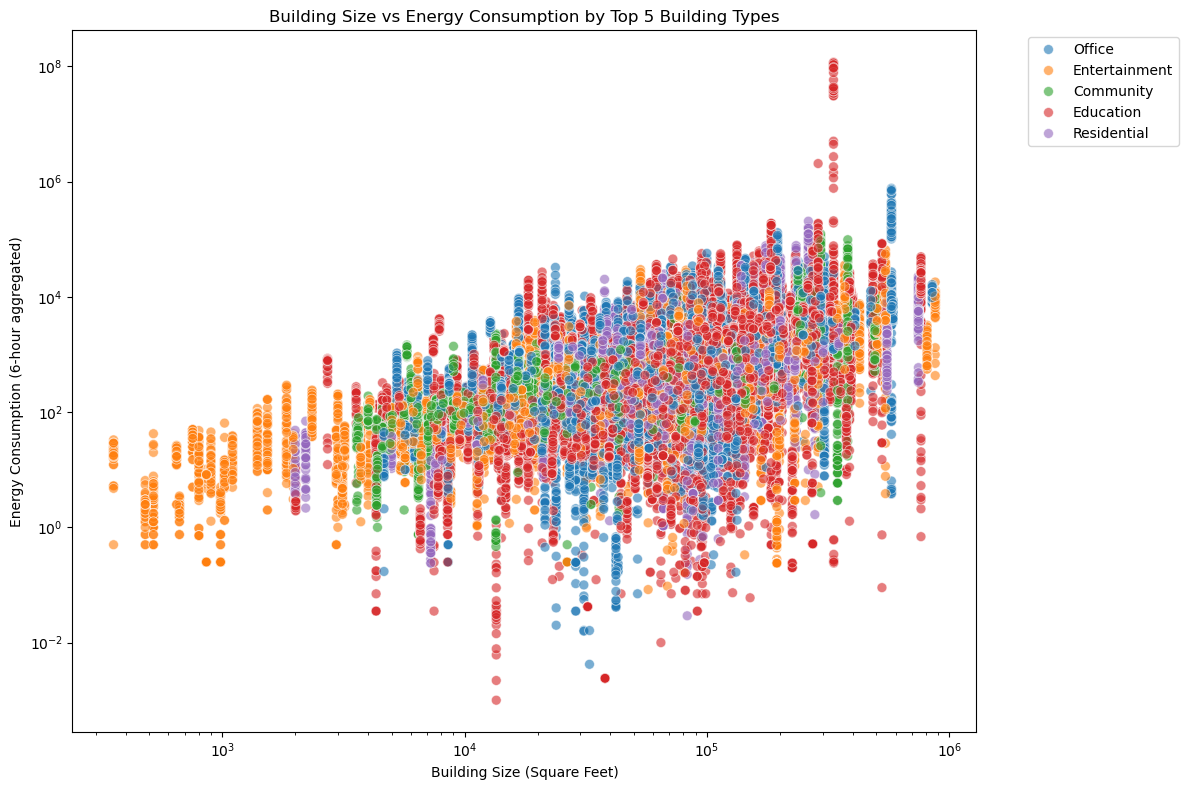

In [101]:
# Scatter plot 1 - Building size against energy consumption by primary usage

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filter out zero energy consumption to investigate the pattern for active buildings 
sample_df = feature_df_clean.filter(feature_df_clean['energy_value'] > 0)

# Sample data for better visualization 
sample_df = feature_df_clean.sample(0.05, seed=42).toPandas()

# Get top N most common building types
top_n = 5
top_building_types = sample_df['primary_use'].value_counts().head(top_n).index.tolist()

# Filter to only show top N types
sample_df_filtered = sample_df[sample_df['primary_use'].isin(top_building_types)]

plt.figure(figsize=(12, 8))
sns.scatterplot(data=sample_df_filtered, 
                x='square_feet', 
                y='energy_value', 
                hue='primary_use', 
                alpha=0.6,
                s=50)

plt.xlabel('Building Size (Square Feet)')
plt.ylabel('Energy Consumption (6-hour aggregated)')
plt.title(f'Building Size vs Energy Consumption by Top {top_n} Building Types')
plt.yscale('log')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Discussion:** <br>
To answer whether larger buildings consume more energy, we plot a graph to investigate the relationship between **building size and energy consumption**, further broken down by building type. We filtered out records with zero energy consumption to focus on **active building** operations. This approach allows us to identify meaningful patterns and relationships between building characteristics and usage.

**Insights:** <br>
1. The plot shows a strong positive correlation indicating that the bigger the building, more energy it will consume.  
2. Entertainment buildings and residential concentrated around 1000 square feet with lower consumption.  
3. Education buildings are widely distributed across all sizes and have large range of consumption.  
4. The wide spread of values for similar building sizes suggests that factors beyond size influence the pattern.  

This analysis demonstrates that while building size is a primary driver, building type introduces substantial variability in the size-consumption relationship.


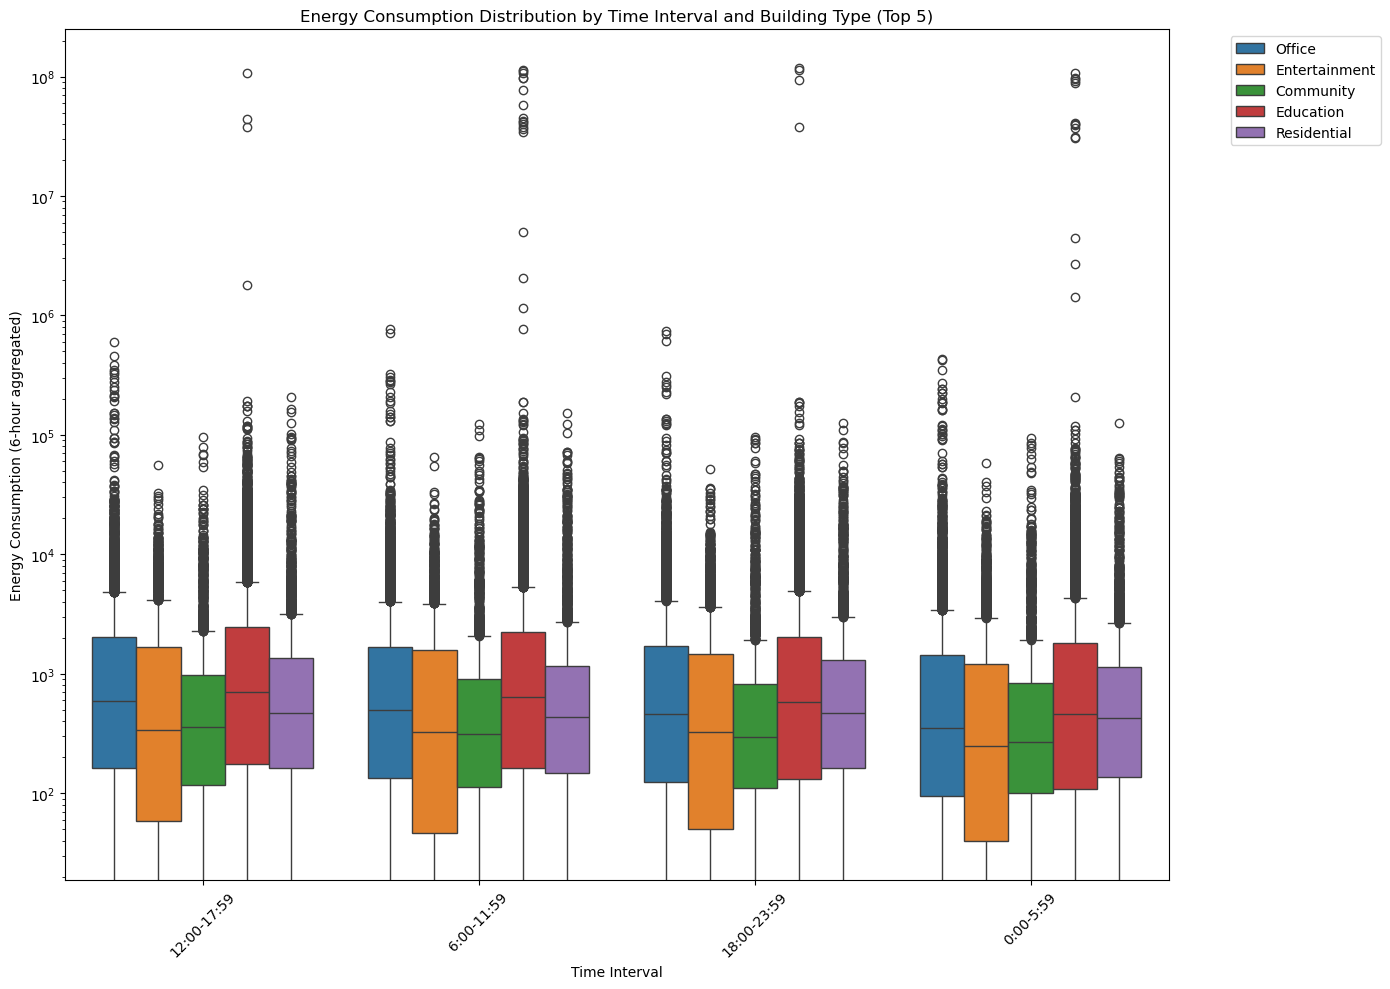

In [102]:
# plot 2 - Box plot with time interval against energy consumption by top 5 primary usage 

plt.figure(figsize=(14, 10))
sns.boxplot(data=sample_df_filtered, 
            x='time_interval', 
            y='energy_value', 
            hue='primary_use')

plt.xlabel('Time Interval')
plt.ylabel('Energy Consumption (6-hour aggregated)')
plt.title('Energy Consumption Distribution by Time Interval and Building Type (Top 5)')
plt.yscale('log')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Discussion:** <br>
To answer the question at energy consumption will be higher at some particular time interval, we plot a graph to investigate the relationship between **time interval and the energy consumption** breakdown by top 5 building's primary usage.

**Insights:** <br>
1. There is a no significant difference between the energy usage across different interval
2. This plot has again showed that Education buildings have wide spread of energy consumption with some extreme values 
3. Education and Office buildings consistently exhibit the highest energy consumption across all time intervals, while Entertainment and Community buildings show relatively lower consumption
4. Residential buildings show moderate consumption levels across all time intervals, with less dramatic variation between day and night periods, reflecting consistent occupancy patterns


The plot suggests that time interval can be an important factor in energy consumption prediction, with building type and operational patterns creating distinct consumption profiles throughout the day.

## Part 2. Feature extraction and ML training <a class="anchor" name="part-2"></a>
In this section, you must use PySpark DataFrame functions and ML packages for data preparation, model building, and evaluation. Other ML packages, such as scikit-learn, should not be used to process the data; however, it’s fine to use them to display the result or evaluate your model.  
### 2.1 Discuss the feature selection and prepare the feature columns

2.1.1 Based on the data exploration from 1.2 and considering the use case, discuss the importance of those features (For example, which features may be useless and should be removed, which feature has a significant impact on the label column, which should be transformed), which features you are planning to use? Discuss the reasons for selecting them and how you plan to create/transform them.  
○	300 words max for the discussion  
○	Please only use the provided data for model building  
○	You can create/add additional features based on the dataset  
○	Hint - Use the insights from the data exploration/domain knowledge/statistical models to consider whether to create more feature columns, whether to remove some columns  

In [48]:
feature_df_clean.printSchema()

root
 |-- site_id: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- time_interval: string (nullable = false)
 |-- building_id: integer (nullable = true)
 |-- meter_type: string (nullable = true)
 |-- energy_value: double (nullable = true)
 |-- primary_use: string (nullable = true)
 |-- square_feet: integer (nullable = true)
 |-- floor_count: integer (nullable = true)
 |-- row_id: integer (nullable = true)
 |-- year_built: integer (nullable = true)
 |-- latent_y: double (nullable = true)
 |-- latent_s: double (nullable = true)
 |-- latent_r: double (nullable = true)
 |-- is_peak: integer (nullable = true)
 |-- avg_air_temperature: double (nullable = true)
 |-- avg_dew_temperature: double (nullable = true)
 |-- avg_sea_level_pressure: double (nullable = true)
 |-- avg_wind_speed: double (nullable = true)



### Feature Selection

**Target Variable:**  
- `energy_value`: 6-hour energy consumption (prediction target)

**Building Features:**  
- `square_feet`: Indicator of building size which show strong correlation with energy use  
- `floor_count`: Taller buildings may need more cooling/heating  
- `year_built`: Age affects energy efficiency  
- `primary_use`: Different building fucntions influence usage patterns  

**Meter Features:**  
- `time_interval`: Captures daily usage differences (e.g., residential & office might have different active period) 
- `date`: For temporal analysis and seasonality 
- `meter_type`: Different source of energy (different meter type might have different consumption pattern)  

**Weather Features:**  
- `air_temperature`: Major driver of energy use  
- `dew_temperature`: Humidity impacts cooling demand 
- `wind_speed`: High wind speed can have cooling effect impacting the energy usage  
- `is_peak`: Energy consumption is assumed to be higher during peak (coldes / hottest months)

**Features to Drop:**  
- `sea_level_pressure`: Minimal direct influence on energy consumption, pressure changes have no direct impact on heating/cooling systems. Its more relevant for long-term climate modeling, but not short-term building energy consumption 
- `wind_direction` & `cloud_coverage`: No data available  
- `latent_y`, `latent_s`, `latent_r`: Undefined meaning with no meaningful interpretation
- `row_id`, `building_id`, `site_id`: Identifiers has not prediction value  

Based on analysis, `square_feet` shows strong correlation with energy use, while `primary_use` highlights variation across building types. 

---

### Feature Engineering
  
1. **Create new feature**:  
Create another column called `is_weekend` via `dayofweek` to capture operational differences between different type of building  
   
2. **Categorical Transformation**: Convert `meter_type`, `time_interval`, and `primary_use` using `StringIndexer` and One-Hot Encoding. 


**2.2.2**

In [49]:
# Feature Engineering 1: Add is_weekend column

# create building age column and is_weekend column
feature_df_weekend = feature_df_clean.withColumn(
                    "is_weekend",  F.when(F.dayofweek("date").isin([1, 7]), 1).otherwise(0)
                    )
                                                    

In [50]:
# Feature selection 

features_selected = ["energy_value", "square_feet", "floor_count", "year_built", "primary_use",
                   "time_interval", "date", "meter_type", 
                   "avg_air_temperature", "avg_dew_temperature", "avg_wind_speed", "is_peak", "is_weekend"]

feature_df_final =feature_df_weekend.select(*features_selected)

In [51]:
feature_df_final.toPandas().head(3)

/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):


,energy_value,square_feet,floor_count,year_built,primary_use,time_interval,date,meter_type,avg_air_temperature,avg_dew_temperature,avg_wind_speed,is_peak,is_weekend
0,0.0000,387500,6,1967,Education,0:00-5:59,2022-01-01,c,-2.216667,-3.233333,1.450000,1,1
1,24.6568,106511,1,1966,Office,6:00-11:59,2022-01-01,c,-7.316667,-10.466667,4.383333,1,1
2,0.0000,88486,1,2004,Education,12:00-17:59,2022-01-01,c,4.616667,-4.166667,0.250000,1,1


In [52]:
print("Distribution of energy_value:")
feature_df_final.select("energy_value").describe().show()

Distribution of energy_value:
+-------+------------------+
|summary|      energy_value|
+-------+------------------+
|  count|           2300550|
|   mean| 16954.96508037166|
| stddev|1104608.2788096876|
|    min|               0.0|
|    max|        1.254538E8|
+-------+------------------+



In [53]:
zero_count = feature_df_final.filter(feature_df_final["energy_value"] == 0).count()
total_count = feature_df_final.count()
print(f"Zero values: {zero_count} out of {total_count} ({zero_count/total_count*100:.2f}%)")

Zero values: 172241 out of 2300550 (7.49%)


**Discussion on Zero Energy Consumption Values:**

During data exploration, I identified some records with `energy_value = 0`. Initial investigation revealed that these zero values do not seems like data quality issues but rather represent legitimate operational patterns:

1. **Education Buildings on Weekends**: Zero values occur in education buildings during weekends
2. **Operational Patterns**: Different building types have varying operational hours

**Decision**: I decided to retain these zero values in our dataset because:
- They might represent genuine building operational patterns
- Removing them would bias our model toward only active consumption periods
- The model should learn to predict both active and inactive periods
- This approach better reflects real-world energy prediction scenarios where buildings may have periods of zero consumption

### 2.2 Preparing Spark ML Transformers/Estimators for features, labels, and models  <a class="anchor" name="2.2"></a>

**2.2.1 Write code to create Transformers/Estimators for transforming/assembling the columns you selected above in 2.1 and create ML model Estimators for Random Forest (RF) and Gradient-boosted tree (GBT) model.
Please DO NOT fit/transform the data yet.**

In [54]:
feature_df_final.printSchema()

root
 |-- energy_value: double (nullable = true)
 |-- square_feet: integer (nullable = true)
 |-- floor_count: integer (nullable = true)
 |-- year_built: integer (nullable = true)
 |-- primary_use: string (nullable = true)
 |-- time_interval: string (nullable = false)
 |-- date: timestamp (nullable = true)
 |-- meter_type: string (nullable = true)
 |-- avg_air_temperature: double (nullable = true)
 |-- avg_dew_temperature: double (nullable = true)
 |-- avg_wind_speed: double (nullable = true)
 |-- is_peak: integer (nullable = true)
 |-- is_weekend: integer (nullable = false)



In [55]:
# Feature Engineering 2: Use StringIndexer & OHE to transform categorical columns

from pyspark.ml.feature import StringIndexer, OneHotEncoder

#Define the input columns
inputCols=["meter_type", "time_interval", "primary_use" ]

#Define the output columns 
outputCols=[f'{x}_index' for x in inputCols]

#Initialize StringIndexer
indexer = StringIndexer(inputCols=inputCols, outputCols=outputCols)

In [56]:
# Apply OHE transformation to all categorical columns
inputCols_OHE = [x for x in outputCols]
outputCols_OHE = [f'{x}_vec' for x in inputCols]

#Initialize OH Encoder
encoder = OneHotEncoder(inputCols=inputCols_OHE, outputCols=outputCols_OHE)

In [59]:
# Combine scaled numerical + One-hot encoded categorical features
from pyspark.ml.feature import VectorAssembler

num_features = ["square_feet", "floor_count", "year_built", 
                "avg_air_temperature", "avg_dew_temperature", "avg_wind_speed", 
                "is_peak", "is_weekend"]

assemblerInputs = outputCols_OHE + num_features
print(assemblerInputs)

assembler = VectorAssembler(
    inputCols= assemblerInputs,
    outputCol="final_features"
)

['meter_type_vec', 'time_interval_vec', 'primary_use_vec', 'square_feet', 'floor_count', 'year_built', 'avg_air_temperature', 'avg_dew_temperature', 'avg_wind_speed', 'is_peak', 'is_weekend']


In [60]:
# Create ML model Estimators for Random Forest (RF) and Gradient-boosted tree (GBT) model
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor

rf = RandomForestRegressor(featuresCol="final_features", labelCol="energy_value")
gbt = GBTRegressor(featuresCol="final_features", labelCol="energy_value")

**2.2.2. Write code to include the above Transformers/Estimators into two pipelines.
Please DO NOT fit/transform the data yet.**

In [61]:
from pyspark.ml import Pipeline

#Create pipeline for Random Forest Regressor
pipeline_rf = Pipeline(stages=[indexer, encoder, assembler, rf])


pipeline_gbt = Pipeline(stages=[indexer, encoder, assembler, gbt])

### 2.3 Preparing the training data and testing data  
Write code to split the data for training and testing, using 2025 as the random seed. You can decide the train/test split ratio based on the resources available on your laptop.  
Note: Due to the large dataset size, you can use random sampling (say 20% of the dataset). 

In [62]:
# Sample 20% of the data with random seed 2025
sampled_df = feature_df_final.sample(0.2)


#Splitting the sampled data into testing and training set 80% into training and 20% for testing
train, test = sampled_df.randomSplit([0.8, 0.2], seed = 2025)

print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count())) 

Training Dataset Count: 368521
Test Dataset Count: 91997


### 2.4 Training and evaluating models  
2.4.1 Write code to use the corresponding ML Pipelines to train the models on the training data from 2.3. And then use the trained models to predict the testing data from 2.3

In [63]:
# Fit the pipeline to training documents
rf_model = pipeline_rf.fit(train)
gbt_model = pipeline_gbt.fit(train)


# Make predictions on test documents 
rf_prediction = rf_model.transform(test)
gbt_prediction = gbt_model.transform(test)

In [65]:
# rf_prediction.select("building_id", "date", "time_interval", "energy_value", "prediction").orderBy("building_id").show(10)

rf_prediction.select("prediction").show(10)

+-----------------+
|       prediction|
+-----------------+
|563.6031446246651|
|604.7468861278328|
|573.9124273156826|
|604.7468861278328|
|563.6031446246651|
|596.6990858252962|
|581.9602276182193|
|573.9124273156826|
|604.7468861278328|
|573.9124273156826|
+-----------------+
only showing top 10 rows



In [66]:
gbt_prediction.select("prediction").orderBy("building_id").show(10)

+------------------+
|        prediction|
+------------------+
| 245.1326063346552|
|175.25460808255372|
| 221.4330624348551|
| 745.2899259068232|
|175.25460808255372|
|337.75464364788996|
| 165.8739897423717|
| 745.2899259068232|
| 245.1326063346552|
|342.36861236246136|
+------------------+
only showing top 10 rows



In [68]:
# Implement a customised evaluation metric Root Mean Squared Logarithmic Error
from pyspark.sql.functions import log, sqrt, avg, col
import math

def calculate_rmsle(predictions_df, actual_col="energy_value", prediction_col="prediction"):
    
    # Then calculate log of (value + 1)
    df_with_logs = predictions_df.withColumn(
        "log_actual_plus_1", 
        log(col(actual_col) + 1)
    ).withColumn(
        "log_pred_plus_1", 
        log(col(prediction_col) + 1)
    )
    
    # Calculate squared difference of logs
    df_with_squared_diff = df_with_logs.withColumn(
        "squared_log_diff",
        (col("log_pred_plus_1") - col("log_actual_plus_1")) ** 2
    )
    
    # Calculate mean of squared differences
    mean_squared_log_error = df_with_squared_diff.select(
        avg("squared_log_diff").alias("msle")
    ).collect()[0]["msle"]
    
    # Calculate RMSLE
    rmsle = math.sqrt(mean_squared_log_error)
    
    return rmsle


In [69]:
#Evaluate the performance for both models

rf_rmsle = calculate_rmsle(rf_prediction)
print(f"Random Forest RMSLE: {rf_rmsle:.4f}")


gbt_rmsle = calculate_rmsle(gbt_prediction)
print(f"Gradient-boosted Tree RMSLE: {gbt_rmsle:.4f}")

Random Forest RMSLE: 2.8208
Gradient-boosted Tree RMSLE: 2.4423


2.4.2 For both models (RF and GBT): with the test data, decide on which metrics to use for model evaluation and discuss which one is the better model (no word limit; please keep it concise). You may also use a plot for visualisation (not mandatory).

### Model Evaluation Discussion:
Based on the RMSLE evaluation, **Gradient-boosted Tree model** (2.44) is **performing better** with a 0.38 lower RMSLE score than Random Forest model (2.82) which suggest it is a better model in predicting energy consumption for our case. The model can better handle the diverse building types and operational patterns in the dataset.

**Why GBT performs better:**

1. **Sequential learning**: 
- GBT's boosting approach allows it to learn from previous prediction errors, where each new tree corrects the errors of the previous ones. This reduces bias and variance, making it more effective at capturing complex patterns in energy consumption data 
- RF builds many decision trees independently on bootstrapped samples and averages their predictions, it reduces variance but doesn’t reduce bias.


2. **Handling non-linear relationships**: 
- Building energy consumption involves complex interactions between weather, building characteristics, and usage patterns, making it a non-linear pattern
- GBT’s sequential error-correction makes it better at capturing these complex relationships
- RF may miss subtler patterns since it treats all trees equally without focused correction

3. **Robust to data imbalance**: 
- The energy consumption has a wide range of scales and varies largely across different building 
- The logarithmic nature of RMSLE makes it sensitive to prediction errors across different scales. GBT's ensemble approach provides better stability across the wide range of energy consumption values.
- RF might underfit them because it averages across the whole population

4. **Feature interaction**: 
- GBT captures feature interactions (e.g. building size × weather conditions × time of day) that are crucial for accurate energy prediction
- Random Forest trees are built independently and then averaged and will not emphasize specific, nuanced interactions the way GBT does


**Conclusion:** <br>
**Gradient Boosted Trees** is the **recommended model** for building energy consumption prediction due to its better performance on the RMSLE metric and its ability to capture the complex, non-linear relationships inherent in building energy data.

---
### Evaluation Metrics Discussion:

**Why this custom RMSLE is better than the conventional RMSE:**
- Root Mean Square Error (**RMSE**) is **scale-sensitive**:, it penalizes large errors more heavily while custom **RMSLE** take logarithm which **reduces the penalty for under/over-prediction** on very large values 
- RMSLE takes logs of predictions and actuals and compares relative differences
- As energy usage differs massively across building types, RMSLE works well when target values span several orders of magnitude (small residential housing vs large building)
- It emphasizes **proportional differences** (e.g. predicting 1000 vs 1200 is less critical than 10 vs 200)
- RMSLE is more forgiving of large errors when the true values are very high (predicting 20,000 instead of 25,000)
- But it strongly penalizes underestimation of small values (predicting 2 instead of 10). This is desirable in energy prediction, where ignoring small buildings could lead to biased conclusions
- Adding +1 before log also ensures RMSLE can handle zero values in the dataset (which RMSE cannot if values vary too wildly)




2.4.3 3.	Save the better model (you’ll need it for A2B).
(Note: You may need to go through a few training loops or use more data to create a better-performing model.)

In [70]:
# Try multiple training loops with different sampling sizes

def train_and_evaluate_model(pipeline, train_data, test_data, model_name):

    # Train the model
    model = pipeline.fit(train_data)
    
    # Make predictions
    predictions = model.transform(test_data)
    
    # Calculate RMSLE
    rmsle = calculate_rmsle(predictions)
    
    print(f"{model_name} - RMSLE: {rmsle:.4f}")
    
    return model, predictions, rmsle

In [71]:
# Save the best results
best_rmsle = float('inf')
best_model = None
best_model_name = ""


# Try different sampling sizes
sampling_rates = [0.15, 0.2, 0.25, 0.3]

for rate in sampling_rates:
    print(f"\nTraining with {rate*100}% sampling")
    
    # Sample data
    sampled_data = feature_df_final.sample(rate, seed=2025)
    train_data, test_data = sampled_data.randomSplit([0.8, 0.2], seed=2025)
    
    # Train GBT (our best model based on the previous evaluation)
    gbt_model, gbt_predictions, gbt_rmsle = train_and_evaluate_model(
        pipeline_gbt, train_data, test_data, f"GBT ({rate*100}%)"
    )
    
    if gbt_rmsle < best_rmsle:
        best_rmsle = gbt_rmsle
        best_model = gbt_model
        best_model_name = f"GBT ({rate*100}%)"
        print(f"New best model - RMSLE: {best_rmsle:.4f}")


print(f"Best Model: {best_model_name}")
print(f"Best RMSLE: {best_rmsle:.4f}")


Training with 15.0% sampling
GBT (15.0%) - RMSLE: 2.5506
New best model - RMSLE: 2.5506

Training with 20.0% sampling
GBT (20.0%) - RMSLE: 2.4569
New best model - RMSLE: 2.4569

Training with 25.0% sampling
GBT (25.0%) - RMSLE: 2.4099
New best model - RMSLE: 2.4099

Training with 30.0% sampling
GBT (30.0%) - RMSLE: 2.4385
Best Model: GBT (25.0%)
Best RMSLE: 2.4099


In [72]:
# Save the best model
best_model.save("a2a_best_model")
#best_model.write().overwrite().save("a2a_best_model")

### Part 3. Hyperparameter Tuning and Model Optimisation <a class="anchor" name="part-3"></a>  
Apply the techniques you have learnt from the labs, for example, CrossValidator, TrainValidationSplit, ParamGridBuilder, etc., to perform further hyperparameter tuning and model optimisation.  
The assessment is based on the quality of your work/process, not the quality of your model. Please include your thoughts/ideas/discussions.

**3.1**

In [73]:
#Loading the Pipeline Model From the filesystem
from pyspark.ml import PipelineModel
pipelineModel = PipelineModel.load('a2a_best_model')

In [74]:
# Accessing the parameters in the best model
best_model.stages[-1].extractParamMap()

{Param(parent='GBTRegressor_d57f91ea1a03', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='GBTRegressor_d57f91ea1a03', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='GBTRegressor_d57f91ea1a03', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regr

In [93]:
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplit

# Create ParamGrid for TrainValidationSplit
dtparamGrid = (ParamGridBuilder()
    .addGrid(gbt.maxDepth, [3, 4, 6])
    .addGrid(gbt.maxIter, [10, 30, 50])
    .build()
)

In [94]:
# Define an evaluator to be used for evaluating the model 
from pyspark.ml.evaluation import RegressionEvaluator

dtevaluator = RegressionEvaluator(
    labelCol="energy_value", 
    predictionCol="prediction", 
    metricName="rmse"
)

In [95]:
# Run the model with TrainValidationSplit
dttv = TrainValidationSplit(estimator = pipeline_gbt,
                      estimatorParamMaps = dtparamGrid,
                      evaluator = dtevaluator,
                      trainRatio = 0.8,
                      seed=2025)

model = dttv.fit(train)

In [96]:
# Get the best model
bestModel_tv = model.bestModel

print(bestModel_tv.stages[-1]._java_obj.paramMap())

{
	GBTRegressor_d57f91ea1a03-featuresCol: final_features,
	GBTRegressor_d57f91ea1a03-labelCol: energy_value,
	GBTRegressor_d57f91ea1a03-maxDepth: 6,
	GBTRegressor_d57f91ea1a03-maxIter: 30
}


In [97]:
# Make predictions with the best tuned model
tuned_predictions = bestModel_tv.transform(test)


# Evaluate the tuned model with RMSLE (your preferred metric)
tuned_rmsle = calculate_rmsle(tuned_predictions, actual_col="energy_value", prediction_col="prediction")
print(f"Tuned Model RMSLE: {tuned_rmsle:.4f}")

# Compare with original model
print(f"Original Model RMSLE: 2.4099")
print(f"Improvement: {2.4099 - tuned_rmsle:.4f}")

Tuned Model RMSLE: 2.3462
Original Model RMSLE: 2.4099
Improvement: 0.0637


**3.2**

### Discussion:
**Tuning Approach:** <br>
In the performance tuning section, I have total **9 combinations** to test. I am using `TrainValidationSplit` instead of CrossValidator as it is less expensive and more computationally efficient.

During tuning process, I used the default RMSE (Root Mean Square Error) evaluator instead of RMSLE for the following reasons:
1. **Computational Efficiency:** RMSE is a built-in Spark MLlib evaluator that works seamlessly with TrainValidationSplit, significantly reducing computation time compared to a custom RMSLE evaluator.
2. **Consistency with Framework:** Using the standard evaluator ensures compatibility and reliability with Spark's tuning framework, avoiding potential issues with custom evaluator implementations.

After hyperparameter tuning, I evaluate the best model using RMSLE on the test set to ensure the final performance metric aligns with my previous evaluation metric to ensure its fair to make comparison across the models. This two-step approach (RMSE for tuning, RMSLE for final evaluation) provides both efficiency and accuracy.


**Key Hyperparameters to Tune for GBT:**<br>
I focused on two key hyperparameters that have the highest impact on Gradient Boosted Tree performance:
 - **maxDepth:** Maximum depth of trees which controls the maximum depth of individual trees
 - **maxIter:** Number of boosting iterations  which controls the number of boosting iterations

**Choose of parameters and its range:**
1. **maxDepth** 
- Impact: The deeper the trees, the more complex the models however, might lead to higher overfitting risk
- Range taken for tuning: [3, 4, 6]
- Reasoning: 5 is the number of depth used in the default model before tuning. I test the impact with a smaller depth (3 and 4) and higher depth (6). The enery consumption dataset has complex interactions between various features, so deeper trees might help

2. **maxIter** (Number of Boosting Iterations)
- Impact: With more iterations, the model tends to have lower bias as it keeps learning from the previous model. However, too many trees may start memorizing noise in the training set, making the model complex and increasing the risk of overfitting.
- Range taken for tuning: [10, 30, 50]
- Reasoning: The base model is using 20 iterations by default. So, I start conservatively with 10 iterations then add to a higher number of 30 and 50 to capture complex patterns. 

**Results and performance impact:** <br>
- Base Model RMSLE: 2.4099
- Tuned Model RMSLE: 2.3462

The hyperparameter tuning process successfully identified optimal parameter combinations with `maxDepth =6` and `maxIter=30` that improved model performance by around **2.6%**. The tuned model has both higher number of depth and iteration, indicating a more complex model works better for energy prediction. 

**3.3**

In [98]:
# Save the best model
bestModel_tv.save("a2a_best_tuned_model")

### Part 4: Data Ethics, Privacy, and Security

### Definitions
- **Data ethics:** moral principles governing how data is collected, processed, and used. It emphasizes fairness, transparency, accountability, and the responsible application of analytics to prevent harm (Floridi & Taddeo, 2016).  

- **Data privacy:** is the protection of personal information from misuse, ensuring individuals control how their data is shared and used (Custers, 2019).  

- **Data security:** involves the technical and organizational measures—such as encryption, access controls, and intrusion detection—designed to protect data from unauthorized access, breaches, or corruption (Zhang et al., 2019).


### Significance in Today's Data-Driven World
In our building energy prediction case study, we processed sensitive data including building locations, energy consumption patterns, and operational characteristics. This convergence of personal and commercial data raises critical ethical questions about consent, purpose limitation, and data minimization that are increasingly relevant as organizations collect vast amounts of information.


---
### Data Privacy 
**Challenges and Importance:**<br>
The scale and complexity of big data make traditional privacy protection methods inadequate. In our dataset, even aggregated energy consumption patterns could potentially reveal sensitive information about building occupancy and operations.

Real-world cases show how serious these risks can be, for example the Netflix Prize dataset, released in 2006 for a machine learning competition, was believed to be anonymized. However, researchers were able to re-identify individuals by linking it with IMDb movie ratings, exposing personal viewing habits. This example demonstrates how anonymization alone may not sufficiently protect privacy in big data.

**Regulatory Framework:**<br>
The General Data Protection Regulation (GDPR) establishes principles such as data minimization, purpose limitation, and explicit consent, requiring organizations to justify why and how data is collected. In the context of our energy prediction project, this means ensuring that data collection is limited to legitimate purposes (e.g., optimizing energy efficiency) and that appropriate safeguards are applied. Similar frameworks, like Australia’s Privacy Act 1988, reinforce transparency and accountability, ensuring individuals retain control over how their data is used.

**Privacy-Preserving Techniques:**<br>
Differential privacy, homomorphic encryption, and secure multi-party computation offer promising solutions. For building energy data, implementing k-anonymity (ensuring each record is indistinguishable from k-1 others) could protect individual building privacy while maintaining model utility.

---
### Summary

The analysis reveals that data privacy in big data processing requires a multi-layered approach combining regulatory compliance, technical safeguards, and ethical considerations. The convergence of regulatory frameworks like GDPR and Australia's Privacy Act with technical solutions such as differential privacy and k-anonymity provides a comprehensive approach to protecting individual privacy while enabling valuable data analytics. Organizations must balance the potential benefits of big data with the fundamental right to privacy, implementing both legal compliance and technical measures to maintain public trust in an increasingly data-driven world.


## References:
Please add your references below:

- Custers, B. (2019). *The protection of consumer data in the era of big data analytics*. *Computer Law & Security Review, 35*(5), 105354. https://doi.org/10.1016/j.clsr.2019.05.001  

- Floridi, L., & Taddeo, M. (2016). What is data ethics? *Philosophical Transactions of the Royal Society A: Mathematical, Physical and Engineering Sciences, 374*(2083), 20160360. https://doi.org/10.1098/rsta.2016.0360  

- Narayanan, A., & Shmatikov, V. (2008). Robust de-anonymization of large sparse datasets. *2008 IEEE Symposium on Security and Privacy (sp 2008)*, 111–125. https://doi.org/10.1109/SP.2008.33  

- Office of the Australian Information Commissioner (OAIC). (n.d.). *Privacy Act 1988*. Australian Government. https://www.oaic.gov.au/privacy/the-privacy-act  

- Sweeney, L. (2002). k-anonymity: A model for protecting privacy. *International Journal of Uncertainty, Fuzziness and Knowledge-Based Systems, 10*(5), 557–570. https://doi.org/10.1142/S0218488502001648  

- Voigt, P., & Von dem Bussche, A. (2017). *The EU General Data Protection Regulation (GDPR): A practical guide*. Springer. https://doi.org/10.1007/978-3-319-57959-7  

- Zhang, K., Ni, J., Yang, K., Liang, X., Ren, J., & Shen, X. (2019). Security and privacy in smart city applications: Challenges and solutions. *IEEE Communications Magazine, 55*(1), 122–129. https://doi.org/10.1109/MCOM.2017.1600267CM  

- Dwork, C. (2008). Differential privacy: A survey of results. *Proceedings of the 5th International Conference on Theory and Applications of Models of Computation*, 1–19. https://doi.org/10.1007/978-3-540-79228-4_1  
